# **Import libs**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm import tqdm
import os
import json
from PIL import Image
import warnings
warnings.filterwarnings("ignore")

import torch
from torch.utils.data import DataLoader, random_split, Dataset
import torch.optim as optim

import torchvision
from torchvision import transforms as T
from torchvision.utils import make_grid
from torchvision.transforms import functional as F

# **Utils**

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
root = '/content/drive/MyDrive/detection'
n_epoch = 50


# **Usefull Functions**

In [36]:
class FormulaDataset(Dataset):
    def __init__(self, root=''):
        self.images_list = []
        self.labels = []
        for item in os.listdir(os.path.join(root, 'images')):
            img_path = os.path.join(root, 'images', item)
            self.images_list.append(img_path)
            self.labels.append(os.path.join(root, 'annotation', '.'.join(item.split('.')[:-1]) + '.json'))


    def __getitem__(self, item):
        img_path = os.path.join(self.images_list[item])
        img = Image.open(img_path).convert('RGB')
        img = F.to_tensor(img)

        with open(self.labels[item]) as f:
            load = json.load(f)
            points = []
            for i in range(len(load['shapes'])):
                if (load['shapes'][i]['points'][1][0] < load['shapes'][i]['points'][0][0]) & (load['shapes'][i]['points'][0][1] < load['shapes'][i]['points'][1][1]):
                    points.append(
                        [load['shapes'][i]['points'][1][0],
                         load['shapes'][i]['points'][0][1],
                         load['shapes'][i]['points'][0][0],
                         load['shapes'][i]['points'][1][1]])
                else:
                    continue

        boxes = torch.tensor(points, dtype=torch.float32)
        labels = torch.ones((len(points), ), dtype=torch.int64)
        #
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        #
        return img, target

    def __len__(self):
        return len(self.images_list)

In [37]:
import math
def train_one_epoch(model, optimizer, train_loader, epoch=None):
    model.train()
    total_loss = 0
    with tqdm(train_loader, unit="batch") as tepoch:
        for images, targets in tepoch:
            if epoch is not None:
                tepoch.set_description(f"Epoch {epoch}")
            images = [image.to(device) for image in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            total_loss += losses
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
    return total_loss/len(train_loader)

In [69]:
def evaluate(model, test_dataloader):
    model.eval()
    with torch.no_grad():
        cnt = 0
        for images , targets in test_dataloader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            out = model(images)
            scores = out[0]['scores'].cpu().numpy()
            inds = scores > 0.8
            bxs = out[0]['boxes'].cpu().numpy()
            bxs = bxs[inds]
            gt = targets[0]['boxes'].cpu().numpy()
            # gt = gt[0]
            img = images[0].permute(1, 2, 0).cpu().numpy()
            #----------------------------------------------------------
            fig, ax = plt.subplots(1)
            ax.imshow(img)
            plt.axis('off')
            for j in range(len(gt)):
                rect1 = patches.Rectangle((int(gt[j][0]),int(gt[j][1])),abs(gt[j][0]-gt[j][2]),
                                abs(gt[j][1]-gt[j][3]),linewidth=3,edgecolor='g',facecolor='none')
                ax.add_patch(rect1)
            for i in range(len(bxs)):
                rect = patches.Rectangle((int(bxs[i][0]),int(bxs[i][1])),abs(bxs[i][0]-bxs[i][2]),
                                        abs(bxs[i][1]-bxs[i][3]),linewidth=3,edgecolor='r',facecolor='none',)
                ax.add_patch(rect)


            fig.savefig(f"{root}/output_images/{cnt}.png".format(cnt), dpi=90, bbox_inches='tight')
            cnt = cnt + 1

# **DataLoader**

In [39]:
set_ = FormulaDataset(root=root)
train, test = random_split(set_, (int(9*(len(set_)/10)), len(set_) - int(9*(len(set_)/10))))
len(train), len(test)

(249, 28)

In [40]:
def new_concat(batch):
  return tuple(zip(*batch))

In [41]:
train_loader = DataLoader(train,
                            batch_size=2,
                            shuffle=True,
                            collate_fn=new_concat,
                            pin_memory=True)
test_loader = DataLoader(test,
                            batch_size=1,
                            shuffle=True,
                            collate_fn=new_concat)

# **Model**

In [50]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(1024, 2)
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [75]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.0005,
                            momentum=0.9, weight_decay=0.0005)

In [76]:
num_epochs = 10

for epoch in range(num_epochs):
    loss = train_one_epoch(model, optimizer, train_loader)
    print('epoch [{}]:  \t loss: {}  '.format(epoch, loss))

100%|██████████| 125/125 [01:06<00:00,  1.88batch/s]


epoch [0]:  	 loss: 0.04886176437139511  


100%|██████████| 125/125 [01:06<00:00,  1.89batch/s]


epoch [1]:  	 loss: 0.04820564016699791  


100%|██████████| 125/125 [01:06<00:00,  1.89batch/s]


epoch [2]:  	 loss: 0.047456465661525726  


100%|██████████| 125/125 [01:06<00:00,  1.89batch/s]


epoch [3]:  	 loss: 0.046771906316280365  


100%|██████████| 125/125 [01:06<00:00,  1.87batch/s]


epoch [4]:  	 loss: 0.046950824558734894  


100%|██████████| 125/125 [01:05<00:00,  1.90batch/s]


epoch [5]:  	 loss: 0.04564289376139641  


100%|██████████| 125/125 [01:06<00:00,  1.89batch/s]


epoch [6]:  	 loss: 0.04528076946735382  


100%|██████████| 125/125 [01:05<00:00,  1.90batch/s]


epoch [7]:  	 loss: 0.04414643347263336  


100%|██████████| 125/125 [01:06<00:00,  1.89batch/s]


epoch [8]:  	 loss: 0.04413997754454613  


100%|██████████| 125/125 [01:05<00:00,  1.90batch/s]

epoch [9]:  	 loss: 0.044065117835998535  


In [77]:
torch.save(model, os.path.join(root, 'detection_model_0.044.pt'))

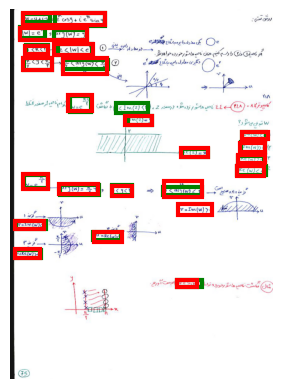

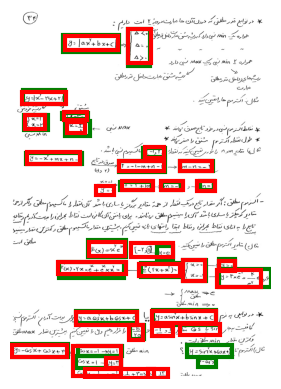

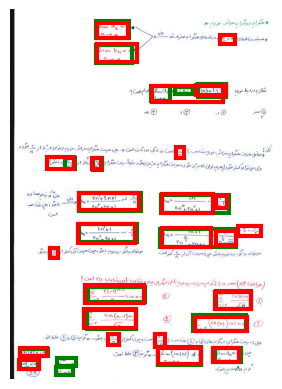

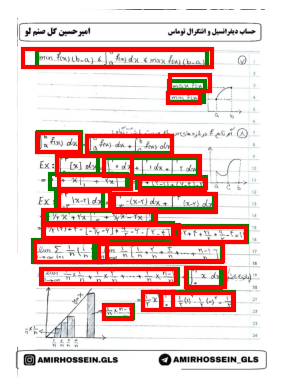

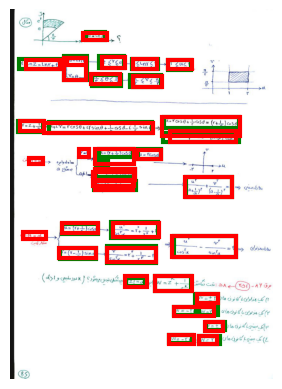

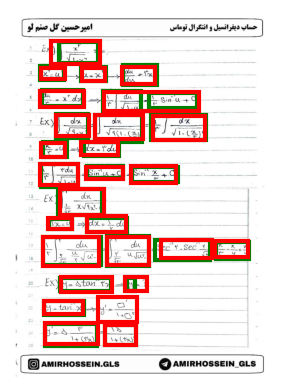

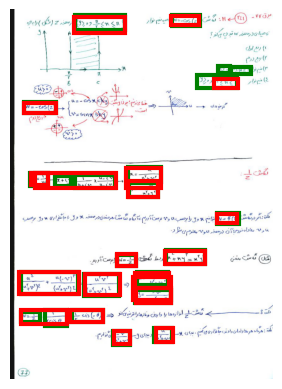

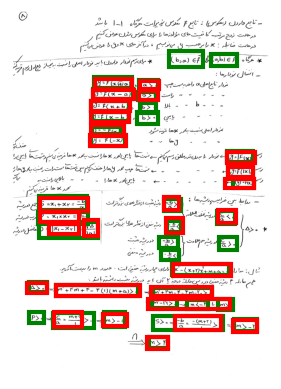

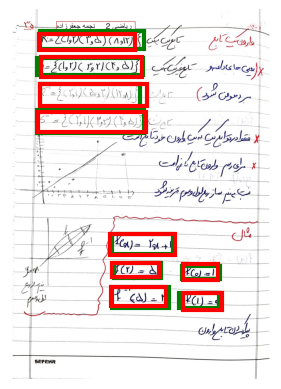

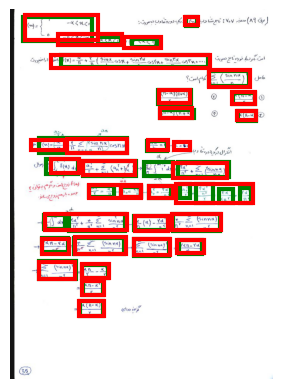

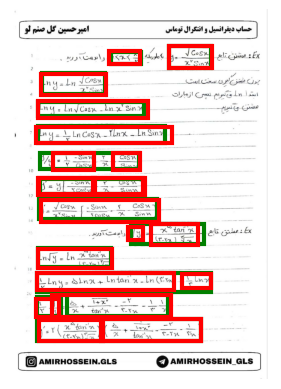

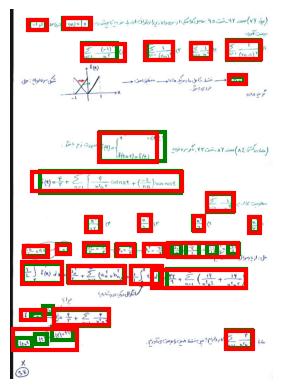

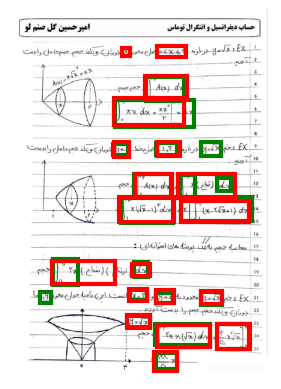

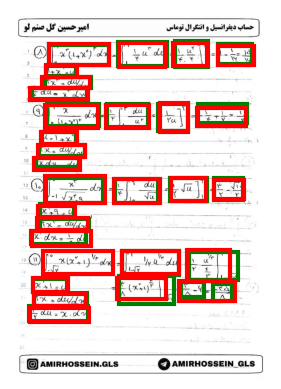

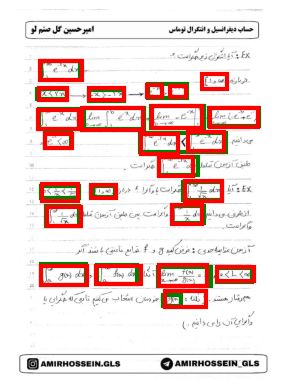

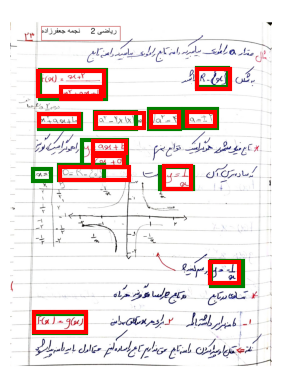

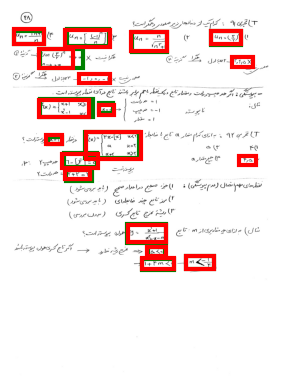

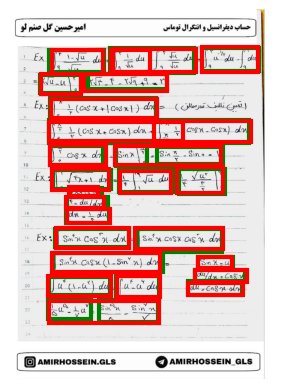

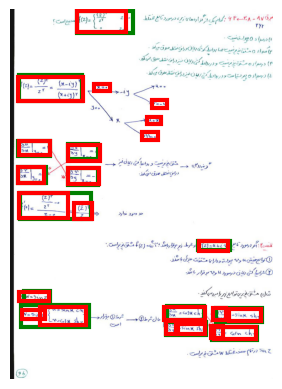

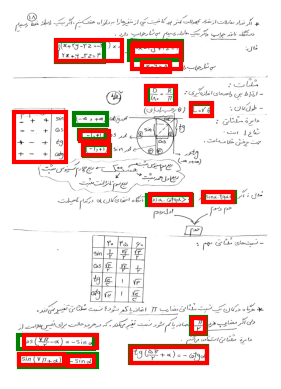

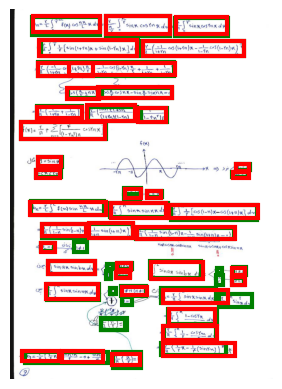

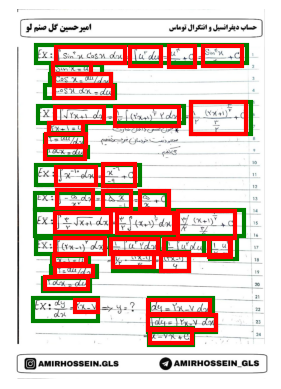

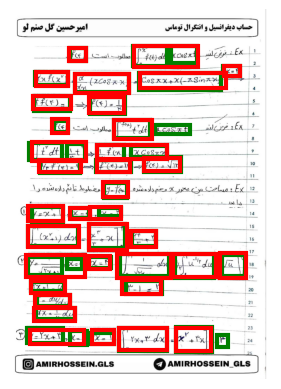

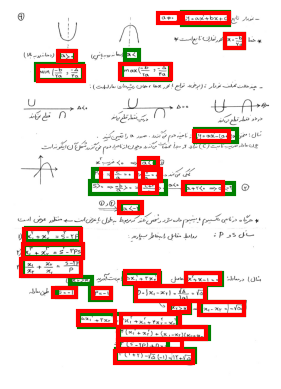

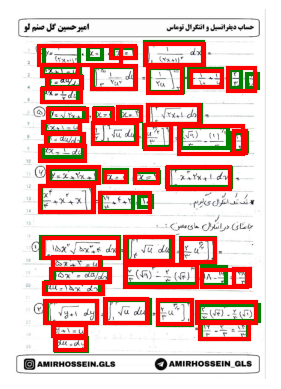

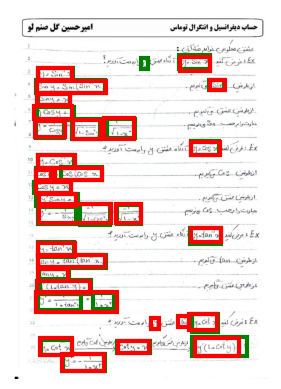

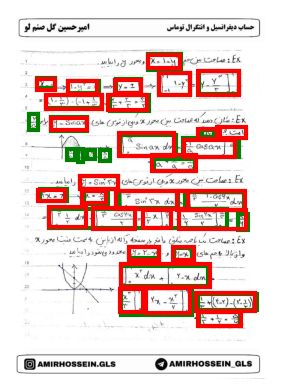

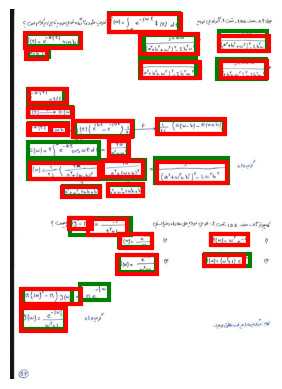

In [78]:
evaluate(model, test_loader)